In [10]:
from typing import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode
from langchain_classic.schema.runnable.config import RunnableConfig
from langchain_core.messages import HumanMessage
from IPython.display import Image, display

import chainlit as cl

In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import MessagesState
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage

In [5]:
@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It might be cloudy in nyc"
    elif city == "sf":
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown city")

In [6]:
tools = [get_weather]
model = ChatGroq(model="openai/gpt-oss-120b", temperature=0)
final_model = ChatGroq(model="openai/gpt-oss-120b", temperature=0)

In [7]:
model = model.bind_tools(tools)
# NOTE: this is where we're adding a tag that we'll can use later to filter the model stream events to only the model called in the final node.
# This is not necessary if you call a single LLM but might be important in case you call multiple models within the node and want to filter events
# from only one of them.
final_model = final_model.with_config(tags=["final_node"])
tool_node = ToolNode(tools=tools)

In [8]:
def should_continue(state: MessagesState) -> Literal["tools", "final"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return "final"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def call_final_model(state: MessagesState):
    messages = state["messages"]
    last_ai_message = messages[-1]
    response = final_model.invoke(
        [
            SystemMessage("Rewrite this in the voice of Al Roker"),
            HumanMessage(last_ai_message.content),
        ]
    )
    # overwrite the last AI message from the agent
    response.id = last_ai_message.id
    return {"messages": [response]}

In [9]:
builder = StateGraph(MessagesState)

builder.add_node("agent", call_model)
builder.add_node("tools", tool_node)
# add a separate final node
builder.add_node("final", call_final_model)

builder.add_edge(START, "agent")
builder.add_conditional_edges(
    "agent",
    should_continue,
)

builder.add_edge("tools", "agent")
builder.add_edge("final", END)

graph = builder.compile()

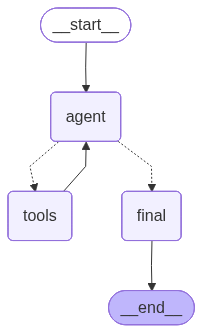

In [12]:
display(Image(graph.get_graph().draw_mermaid_png()))